# Import Library and Upload Data

In [ ]:
!pip install --upgrade transformers huggingface_hub
!pip install pyarrow

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from transformers import BertTokenizer, TFBertModel
import os
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, f1_score
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight
import torch.nn as nn
from transformers import AutoModel, TrainingArguments, Trainer
from transformers import get_linear_schedule_with_warmup
import torch.optim as optim
from collections import defaultdict
import time
import pickle
from torch.utils.data import WeightedRandomSampler

2025-11-28 14:15:44.118605: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764339344.324294      38 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764339344.387893      38 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Preparing column for temporal sentiment analysis

Column that is used for temporal sentiment analysis: overall, reviewTime, reviewText, asin (product id)

In [3]:
merged_df = pd.read_parquet('/kaggle/input/df-top-5-cellphone/sample_df_top5_cellphone.parquet')
merged_df.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,unixReviewTime,vote,title,rank,main_cat,date,price,Review_Count,Min_Date,Max_Date,Review_Period_Days
0,5,True,2012-09-28,AN50X7CK243DC,B005NF5NTK,msaridar,I got this product for my mom since she replac...,1348790400,909,"Anker PowerCore+ Mini, 3350mAh Lipstick-Sized ...","['>#6,626 in Cell Phones & Accessories (See To...",Cell Phones & Accessories,None,$23.99,13095,2011-11-30,2018-06-24,2398
1,5,True,2012-09-08,A34TJ1Z3UVGELL,B005NF5NTK,JS,"it charges my LG ""dumb"" phone, my echo ecigs, ...",1347062400,None,"Anker PowerCore+ Mini, 3350mAh Lipstick-Sized ...","['>#6,626 in Cell Phones & Accessories (See To...",Cell Phones & Accessories,None,$23.99,13095,2011-11-30,2018-06-24,2398
2,5,True,2012-05-22,AMM4QAFLI50X4,B005NF5NTK,carlos adame,"As I received a use in my mobile, and I was ou...",1337644800,None,"Anker PowerCore+ Mini, 3350mAh Lipstick-Sized ...","['>#6,626 in Cell Phones & Accessories (See To...",Cell Phones & Accessories,None,$23.99,13095,2011-11-30,2018-06-24,2398
3,5,True,2012-04-02,A253LFJJDRENNQ,B005NF5NTK,KB,Very compact but able to almost fully charge a...,1333324800,4,"Anker PowerCore+ Mini, 3350mAh Lipstick-Sized ...","['>#6,626 in Cell Phones & Accessories (See To...",Cell Phones & Accessories,None,$23.99,13095,2011-11-30,2018-06-24,2398
4,4,True,2012-02-20,A3GBQUB4A44C4I,B005NF5NTK,Professor305,"Charged my HTC Amaze 4G to 75%, with it being ...",1329696000,7,"Anker PowerCore+ Mini, 3350mAh Lipstick-Sized ...","['>#6,626 in Cell Phones & Accessories (See To...",Cell Phones & Accessories,None,$23.99,13095,2011-11-30,2018-06-24,2398


In [ ]:
# ensure there is no empty column or row. sort value by reviewTime
merged_df = merged_df.dropna(axis=1, how='all')
merged_df = merged_df.sort_values(by='reviewTime').reset_index(drop=True)
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61146 entries, 0 to 61145
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   overall             61146 non-null  int64         
 1   verified            61146 non-null  bool          
 2   reviewTime          61146 non-null  datetime64[ns]
 3   reviewerID          61146 non-null  object        
 4   asin                61146 non-null  object        
 5   reviewerName        61141 non-null  object        
 6   reviewText          61146 non-null  object        
 7   unixReviewTime      61146 non-null  int64         
 8   vote                1598 non-null   object        
 9   title               61146 non-null  object        
 10  rank                61146 non-null  object        
 11  main_cat            61146 non-null  object        
 12  date                11091 non-null  object        
 13  price               61146 non-null  object    

In [ ]:
# map sentiment into positive and negative

def map_sentiment(score):
    if score >= 4: # map positive
        return 1 
    else:         # map negative
        return 0 
        
merged_df['sentiment'] = merged_df['overall'].apply(map_sentiment)
print(merged_df['sentiment'].dtype) 

int64


In [ ]:
# map asin, which is product id, into unique id from 0 to n-1
unique_asins = merged_df['asin'].unique()
asin_to_id = {asin: idx for idx, asin in enumerate(unique_asins)}
id_to_asin = {idx: asin for asin, idx in asin_to_id.items()}
merged_df['asin_id'] = merged_df['asin'].map(asin_to_id)

# asin_mapping_df = pd.DataFrame({
#     'asin': list(asin_to_id.keys()),
#     'asin_id': list(asin_to_id.values())
# })
# asin_mapping_df.to_csv('asin_mapping.csv', index=False)

merged_df.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,unixReviewTime,vote,title,rank,main_cat,date,price,Review_Count,Min_Date,Max_Date,Review_Period_Days,sentiment,asin_id
0,4,True,2011-11-30,A2NH1QZRL3KEXM,B005NF5NTK,Der Kaiser,I thought the cylinder type charger was worth ...,1322611200,2,"Anker PowerCore+ Mini, 3350mAh Lipstick-Sized ...","['>#6,626 in Cell Phones & Accessories (See To...",Cell Phones & Accessories,None,$23.99,13095,2011-11-30,2018-06-24,2398,1,0
1,5,True,2011-12-22,A13NSKPTIRSSQS,B005NF5NTK,callmebob,"Having the Evo 4g, battery life is something t...",1324512000,2,"Anker PowerCore+ Mini, 3350mAh Lipstick-Sized ...","['>#6,626 in Cell Phones & Accessories (See To...",Cell Phones & Accessories,None,$23.99,13095,2011-11-30,2018-06-24,2398,1,0
2,5,False,2012-01-14,A2H1CCSN6M4QNU,B005NF5NTK,Al-Sayed Khalid,when i first got this was happy on how small i...,1326499200,4,"Anker PowerCore+ Mini, 3350mAh Lipstick-Sized ...","['>#6,626 in Cell Phones & Accessories (See To...",Cell Phones & Accessories,None,$23.99,13095,2011-11-30,2018-06-24,2398,1,0
3,4,True,2012-02-20,A3GBQUB4A44C4I,B005NF5NTK,Professor305,"Charged my HTC Amaze 4G to 75%, with it being ...",1329696000,7,"Anker PowerCore+ Mini, 3350mAh Lipstick-Sized ...","['>#6,626 in Cell Phones & Accessories (See To...",Cell Phones & Accessories,None,$23.99,13095,2011-11-30,2018-06-24,2398,1,0
4,5,True,2012-04-02,A253LFJJDRENNQ,B005NF5NTK,KB,Very compact but able to almost fully charge a...,1333324800,4,"Anker PowerCore+ Mini, 3350mAh Lipstick-Sized ...","['>#6,626 in Cell Phones & Accessories (See To...",Cell Phones & Accessories,None,$23.99,13095,2011-11-30,2018-06-24,2398,1,0


In [ ]:
# count number of reviews per year
print("Reviews per year:")
yearly_counts = (merged_df['reviewTime'].dt.year.value_counts().sort_index())
print(yearly_counts)

Reviews per year:
reviewTime
2011        2
2012        6
2014      705
2015    17999
2016    24137
2017    12855
2018     5442
Name: count, dtype: int64


In [ ]:
# only use data from 2015 since 2011-2014 has low amount of data 
merged_df = merged_df[merged_df['reviewTime'].dt.year>=2015].copy()
merged_df.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,unixReviewTime,vote,title,rank,main_cat,date,price,Review_Count,Min_Date,Max_Date,Review_Period_Days,sentiment,asin_id
713,5,True,2015-01-01,A356R2YBP9PWPB,B00MQSMDYU,Sue,Very pleased. This product is great.,1420070400,None,Portable Chargers 16750 RAVPower 16750mAh Exte...,"['>#5,286 in Cell Phones & Accessories (See To...",Cell Phones & Accessories,None,$37.99,13465,2014-09-11,2018-08-09,1428,1,1
714,1,True,2015-01-01,A2GJ4YPGG6W87,B00MQSMDYU,Amazon Customer,It was great when I first got it and then it s...,1420070400,6,Portable Chargers 16750 RAVPower 16750mAh Exte...,"['>#5,286 in Cell Phones & Accessories (See To...",Cell Phones & Accessories,None,$37.99,13465,2014-09-11,2018-08-09,1428,0,1
715,5,True,2015-01-01,A35NYLTL57C84W,B00MQSMDYU,chris fountain,Best portable battery pack that I have owned. ...,1420070400,None,Portable Chargers 16750 RAVPower 16750mAh Exte...,"['>#5,286 in Cell Phones & Accessories (See To...",Cell Phones & Accessories,None,$37.99,13465,2014-09-11,2018-08-09,1428,1,1
716,5,True,2015-01-01,A1XFG7PQ5V04MI,B00MQSMDYU,449greg,"Totally awesome,,,,just as advertised!! You wi...",1420070400,None,Portable Chargers 16750 RAVPower 16750mAh Exte...,"['>#5,286 in Cell Phones & Accessories (See To...",Cell Phones & Accessories,None,$37.99,13465,2014-09-11,2018-08-09,1428,1,1
717,5,True,2015-01-01,A2FVMF4VCRUKIW,B00MQSMDYU,C. Parker,awesome,1420070400,None,Portable Chargers 16750 RAVPower 16750mAh Exte...,"['>#5,286 in Cell Phones & Accessories (See To...",Cell Phones & Accessories,None,$37.99,13465,2014-09-11,2018-08-09,1428,1,1


### Understand the data distribution

sentiment
1    51073
0     9360
Name: count, dtype: int64


<Axes: ylabel='count'>

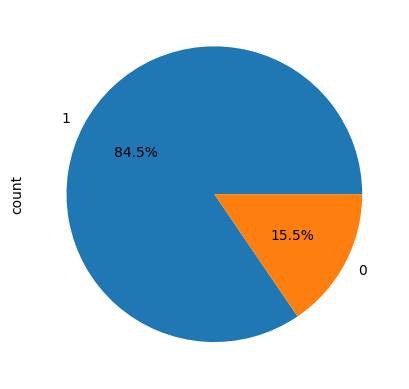

In [ ]:
print(merged_df['sentiment'].value_counts())
merged_df['sentiment'].value_counts().plot.pie(autopct='%1.1f%%')

In [26]:
# review distribution over time
print(f"Time span: {merged_df['reviewTime'].min()} to {merged_df['reviewTime'].max()}")
print(f"Total time span: {(merged_df['reviewTime'].max() - merged_df['reviewTime'].min()).days} days")

Time span: 2015-01-01 00:00:00 to 2018-08-31 00:00:00
Total time span: 1338 days


Reviews per year:
reviewTime
2015    17999
2016    24137
2017    12855
2018     5442
Name: count, dtype: int64


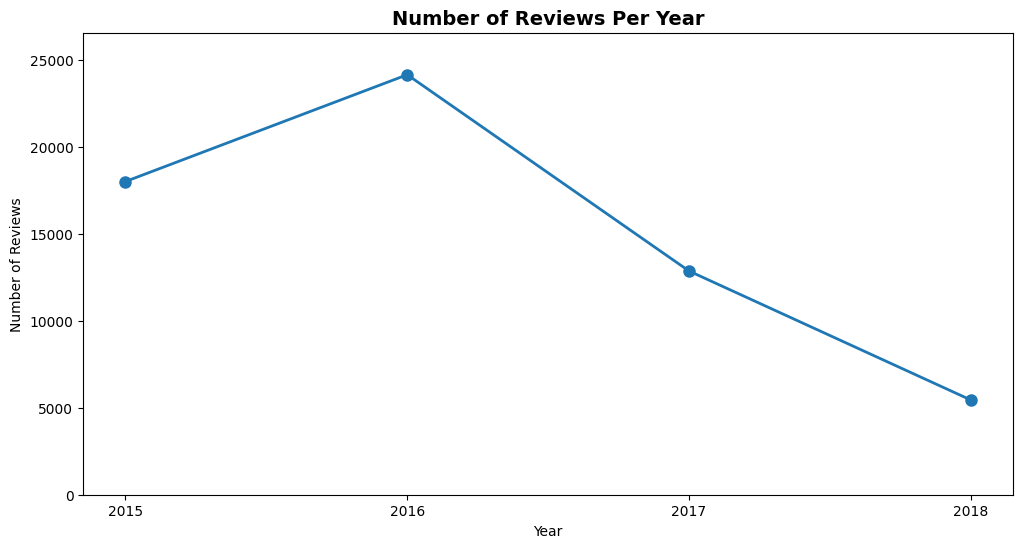

In [ ]:
yearly_counts = (merged_df['reviewTime'].dt.year.value_counts().sort_index())
print("Reviews per year:")
print(yearly_counts)

plt.figure(figsize=(12, 6))
plt.plot(yearly_counts.index, yearly_counts.values, marker='o', linewidth=2, markersize=8)
plt.title('Number of Reviews Per Year', fontsize=14, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.xticks(yearly_counts.index)
plt.ylim(0, yearly_counts.max() * 1.1) 
plt.show()

In [28]:
print("Reviews per month (sample):")
print(merged_df['reviewTime'].dt.to_period('M').value_counts().sort_index().head(10))
print(merged_df['reviewTime'].dt.to_period('M').value_counts().sort_index().tail(10))

Reviews per month (sample):
reviewTime
2015-01     411
2015-02     621
2015-03     684
2015-04     426
2015-05     792
2015-06     958
2015-07    1226
2015-08    2512
2015-09    2587
2015-10    2713
Freq: M, Name: count, dtype: int64
reviewTime
2017-11    1028
2017-12     788
2018-01     858
2018-02     776
2018-03     869
2018-04     885
2018-05     437
2018-06     591
2018-07     558
2018-08     468
Freq: M, Name: count, dtype: int64


In [29]:
reviews_per_product = merged_df.groupby('asin').size()
print("Product Distribution:")
print(f"Total unique products: {len(reviews_per_product)}")
print(f"Average reviews per product: {reviews_per_product.mean():.1f}")
print(f"Min reviews: {reviews_per_product.min():.1f}")
print(f"Max reviews: {reviews_per_product.max():.1f}")

Product Distribution:
Total unique products: 5
Average reviews per product: 12086.6
Min reviews: 10597.0
Max reviews: 13087.0


In [30]:
# sentiment distribution over time
yearly_sentiment = pd.crosstab(merged_df['reviewTime'].dt.year, merged_df['sentiment'], normalize='index')
print(yearly_sentiment)

sentiment          0         1
reviewTime                    
2015        0.117951  0.882049
2016        0.161495  0.838505
2017        0.184753  0.815247
2018        0.177141  0.822859



Average rating by year:
reviewTime
2015    4.491972
2016    4.360981
2017    4.295060
2018    4.313671
Name: overall, dtype: float64


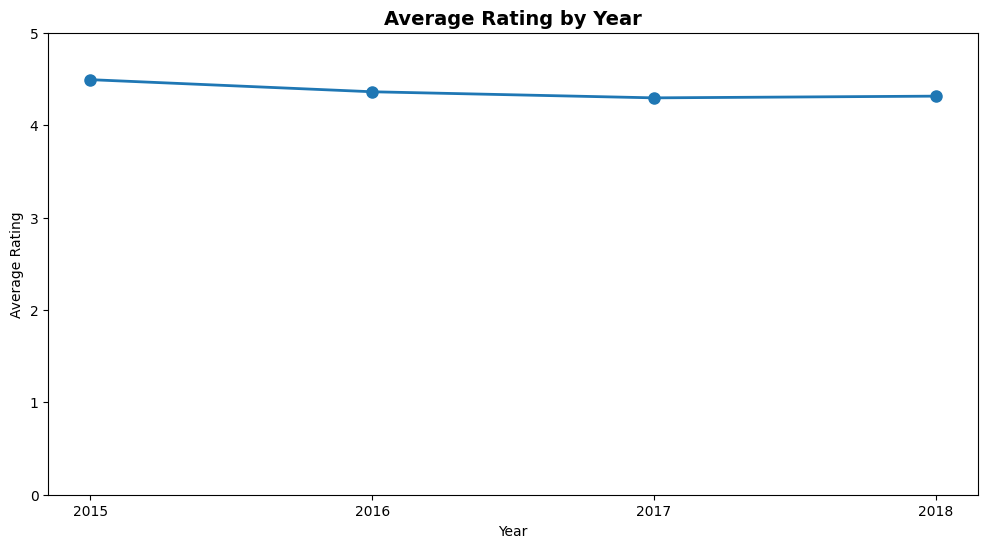

In [ ]:
yearly_ratings = merged_df.groupby(merged_df['reviewTime'].dt.year)['overall'].mean()
print(f"Average rating by year:\n{yearly_ratings}")

plt.figure(figsize=(12, 6))
plt.plot(yearly_ratings.index, yearly_ratings.values, marker='o', linewidth=2, markersize=8)
plt.title('Average Rating by Year', fontsize=14, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.xticks(yearly_ratings.index)
plt.ylim(0, 5)
plt.yticks(range(0, 6))
plt.show()

In [ ]:
# Review length
merged_df['review_length'] = merged_df['reviewText'].str.len()
print("Text Length Distribution")
print(f"Average length: {merged_df['review_length'].mean():.1f} chars")
print(f"Min length: {merged_df['review_length'].min()} chars")
print(f"Max length: {merged_df['review_length'].max()} chars")
print(f"Reviews >512 chars: {(merged_df['review_length'] > 512).sum()}") # just approximation

In [33]:
merged_df.columns

Index(['overall', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'reviewerName', 'reviewText', 'unixReviewTime', 'vote', 'title', 'rank',
       'main_cat', 'date', 'price', 'Review_Count', 'Min_Date', 'Max_Date',
       'Review_Period_Days', 'sentiment', 'asin_id', 'review_length'],
      dtype='object')

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

yearly_analysis = merged_df.groupby([merged_df['reviewTime'].dt.year, 'asin']).agg({
    'sentiment': ['count', lambda x: (x == 1).mean() * 100, lambda x: (x == 0).mean() * 100],
    'overall': 'mean'}).round(2)

yearly_analysis.columns = ['Total_Reviews', 'Positive(%)', 'Negative(%)', 'Avg_Rating']
print("Yearly Sentiment Analysis:")
print(yearly_analysis)

Yearly Sentiment Analysis:
                       Total_Reviews  Positive(%)  Negative(%)  Avg_Rating
reviewTime asin                                                           
2015       B005NF5NTK           4851        87.82        12.18        4.46
           B00MQSMDYU           5460        93.10         6.90        4.68
           B00QN1T6NM           5479        81.07        18.93        4.24
           B00X5RV14Y           1817        96.53         3.47        4.79
           B014EB532U            392        85.97        14.03        4.43
2016       B005NF5NTK           5318        87.57        12.43        4.46
           B00MQSMDYU           4185        89.61        10.39        4.57
           B00QN1T6NM           4794        69.92        30.08        3.90
           B00X5RV14Y           5037        92.69         7.31        4.66
           B014EB532U           4803        79.35        20.65        4.21
2017       B005NF5NTK           2333        76.77        23.23        4.1

In [35]:
merged_df.columns

Index(['overall', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'reviewerName', 'reviewText', 'unixReviewTime', 'vote', 'title', 'rank',
       'main_cat', 'date', 'price', 'Review_Count', 'Min_Date', 'Max_Date',
       'Review_Period_Days', 'sentiment', 'asin_id', 'review_length'],
      dtype='object')

### Handle time features

In [11]:
min_year = merged_df['reviewTime'].dt.year.min() 
merged_df['review_year'] = merged_df['reviewTime'].dt.year - min_year
merged_df['review_month'] = merged_df['reviewTime'].dt.month - 1
merged_df['review_dayofweek'] = merged_df['reviewTime'].dt.dayofweek

product_review_sequence = merged_df.groupby('asin').cumcount()
merged_df['review_sequence'] = product_review_sequence

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


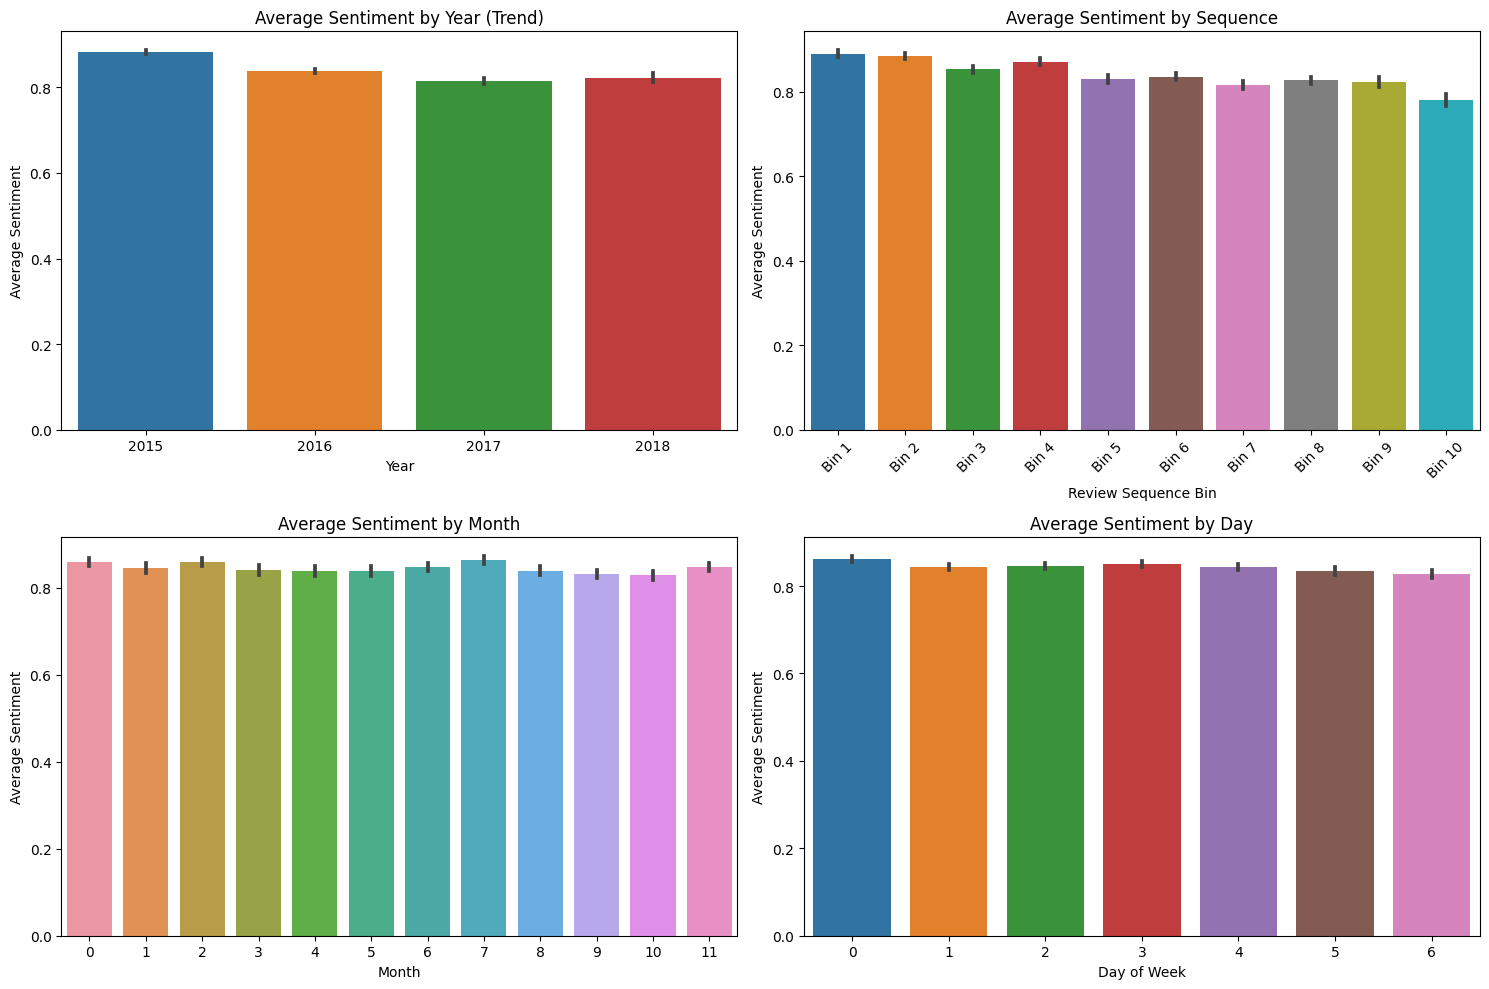

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
# 1. Year vs Sentiment 
sns.barplot(x='review_year', y='sentiment', data=merged_df, ax=axes[0, 0])
axes[0, 0].set_title("Average Sentiment by Year (Trend)")
axes[0, 0].set_xlabel("Year")
axes[0, 0].set_ylabel("Average Sentiment")
axes[0, 0].set_xticklabels([2015, 2016, 2017, 2018])

# # 2. Sequence vs Sentiment 
merged_df['seq_bin'] = pd.cut(merged_df['review_sequence'], bins=10)
bin_labels = [f'Bin {i+1}' for i in range(10)]
sns.barplot(x='seq_bin', y='sentiment', data=merged_df, ax=axes[0, 1])
axes[0, 1].set_title("Average Sentiment by Sequence")
axes[0, 1].set_xlabel("Review Sequence Bin")
axes[0, 1].set_ylabel("Average Sentiment")
axes[0, 1].set_xticklabels(bin_labels, rotation=45)

# # 3. Month vs Sentiment 
sns.barplot(x='review_month', y='sentiment', data=merged_df, ax=axes[1, 0])
axes[1, 0].set_title("Average Sentiment by Month")
axes[1, 0].set_xlabel("Month")
axes[1, 0].set_ylabel("Average Sentiment")

# # 4. Day vs Sentiment 
sns.barplot(x='review_dayofweek', y='sentiment', data=merged_df, ax=axes[1, 1])
axes[1, 1].set_title("Average Sentiment by Day")
axes[1, 1].set_xlabel("Day of Week")
axes[1, 1].set_ylabel("Average Sentiment")
plt.tight_layout()
plt.show()

Since the day feature does not really show any trend compared to others, day will not be used for modelling

### Handle text preprocessing

In [ ]:
def text_preprocessing(text):
    text = str(text)
    text = ' '.join(text.split())
    return text

class ReviewDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        
        # Apply Simple Preprocessing 
        review_text = text_preprocessing(row['reviewText'])
        
        # Tokenization 
        encoding = self.tokenizer.encode_plus(
            review_text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt', 
        )
        
        # Additional Features (ID and temporal) and Targets 
        asin_id = torch.tensor(row['asin_id'], dtype=torch.long)
        sentiment_label = torch.tensor(row['sentiment'], dtype=torch.long)
        review_year = torch.tensor(row['review_year'], dtype=torch.long)
        review_month = torch.tensor(row['review_month'], dtype=torch.long)
        review_sequence = torch.tensor(row['review_sequence'], dtype=torch.long)

        # setup for data loader
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'asin_id': asin_id,
            'review_year': review_year,
            'review_month': review_month, 
            'review_sequence': review_sequence,
            'targets': sentiment_label
        }

In [ ]:
def create_data_loaders(df, tokenizer, max_len, batch_size, main_train_ratio=0.8, val_in_train_ratio=0.2):
    # Sort the entire dataset by the review time column before splitting
    df = df.sort_values(by='reviewTime').reset_index(drop=True)
    
    # Split to train, val, and test
    total_size = len(df)
    outer_train_size = int(main_train_ratio * total_size)
    train_val_df = df[df['reviewTime'].dt.year.isin([2015, 2016, 2017])]
    test_df = df[df['reviewTime'].dt.year == 2018]
    train_df = df[df['reviewTime'].dt.year.isin([2015, 2016])]
    val_df = df[df['reviewTime'].dt.year == 2017]

    # calculate the weights for the imbalanced dataset
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_labels = train_val_df['sentiment'].values
    classes = np.unique(train_labels)
    weights_np = compute_class_weight("balanced", classes=classes, y=train_labels)
    weights_tensor = torch.tensor(weights_np, dtype=torch.float).to(device)
    print(f"Weights (Tensor): {weights_tensor}")

    train_df = train_df.reset_index(drop=True)
    val_df = val_df.reset_index(drop=True)
    test_df = test_df.reset_index(drop=True)

    print(f"Train Set: {len(train_df)} reviews, ({len(train_df)/total_size*100:.2f}% of total)")
    print(f"Validation Set: {len(val_df)} reviews, ({len(val_df)/total_size*100:.2f}% of total)")
    print(f"Test Set: {len(test_df)} reviews, ({len(test_df)/total_size*100:.2f}% of total)")
    
    # call ReviewDataset
    train_dataset = ReviewDataset(train_df, tokenizer, max_len)
    val_dataset = ReviewDataset(val_df, tokenizer, max_len)
    test_dataset = ReviewDataset(test_df, tokenizer, max_len)

    train_data_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True
    )
    
    val_data_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False
    )

    test_data_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False
    )
    
    return train_data_loader, val_data_loader, test_data_loader, weights_tensor

# Training Model 

In [ ]:
class TemporalBERTClassifier(nn.Module):
    def __init__(self, bert_model_name, num_sentiment_classes, num_unique_products, num_years=4, num_months=13, product_embedding_dim=50, time_embedding_dim=16):
        super(TemporalBERTClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(bert_model_name)
        bert_output_dim = self.bert.config.hidden_size 
        
        # embedding for product id
        self.product_embedding = nn.Embedding(
            num_embeddings=num_unique_products,  # Total count of unique products
            embedding_dim=product_embedding_dim      
        )
        
        # embedding for temporal features
        self.year_embedding = nn.Embedding(num_years, time_embedding_dim)
        self.month_embedding = nn.Embedding(num_months, time_embedding_dim//2)  # 8 dim
        # Project sequence into time embedding dimension
        self.sequence_projection = nn.Linear(1, time_embedding_dim//4) 

        self.emb_dropout = nn.Dropout(0.3)

        total_combined_dim = (
            bert_output_dim +          # 768 
            product_embedding_dim +    # 50 
            time_embedding_dim +       # 16 (year)
            time_embedding_dim//2 +    # 8 (month) 
            time_embedding_dim//4      # 4 (sequence)
        )  
        
        # Final Classification
        self.batch_norm = nn.BatchNorm1d(total_combined_dim)
        self.classifier = nn.Sequential(
            nn.Linear(total_combined_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_sentiment_classes))

    def forward(self, input_ids, attention_mask, asin_id, review_year, review_month, review_sequence):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        # Extract the vector for the [CLS] token 
        cls_output = outputs.last_hidden_state[:, 0, :] 
        
        # embedding for product id
        product_vec = self.product_embedding(asin_id) 
        
        # Time Embeddings
        year_emb = self.year_embedding(review_year)
        month_emb = self.month_embedding(review_month)
        sequence_emb = self.sequence_projection(review_sequence.unsqueeze(1).float())
         
        # Concatenate all features (Feature Fusion)
        combined_features = torch.cat([
            cls_output,                 # BERT output
            product_vec,                # ID embedding
            year_emb,                   # Year embedding
            month_emb,                  # Month embedding           
            sequence_emb                # Review sequence projection
        ], dim=-1)

        combined_features = self.batch_norm(combined_features)
        # final classification
        logits = self.classifier(combined_features)
        return logits

In [ ]:
def train_epoch_fn(model, data_loader, loss_fn, optimizer, device, scheduler=None):
    model = model.train()  # Set model to training mode
    
    losses = []
    all_targets = []
    all_preds = []
    
    for data in tqdm(data_loader, desc="Training"):
        # Move tensors to the target device
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        
        # Set custom features
        asin_id = data['asin_id'].to(device)
        review_year = data['review_year'].to(device)
        review_month = data['review_month'].to(device)
        review_sequence = data['review_sequence'].to(device)
        
        # Set target Label
        targets = data['targets'].to(device)

        # Forward Pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            asin_id=asin_id,
            review_year=review_year,
            review_month=review_month,
            review_sequence=review_sequence
        )
        
        # Calculate loss 
        loss = loss_fn(outputs, targets)
        
        # Get the prediction results
        _, preds = torch.max(outputs, dim=1)
        
        # Store the results for evaluation with metrics
        all_targets.extend(targets.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        losses.append(loss.item())
        
        # Backward Pass 
        optimizer.zero_grad() 
        loss.backward()       
        
        # Gradient Clipping 
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        # Update model parameters
        optimizer.step()      
        
        # Update the learning rate
        if scheduler:
            scheduler.step()  

    # calculate the average loss, accuracy, and macro f1 score
    avg_loss = sum(losses) / len(data_loader)
    accuracy = accuracy_score(all_targets, all_preds)
    macro_f1 = f1_score(all_targets, all_preds, average='macro')
    report = classification_report(all_targets, all_preds, output_dict=True, zero_division=0)
    return avg_loss, accuracy, macro_f1, report

In [ ]:
def eval_epoch_fn(model, data_loader, loss_fn, device, desc="Evaluation"):
    # Set model to evaluation mode 
    model = model.eval()  
    losses = []
    all_targets = []
    all_preds = []
    
    with torch.no_grad(): 
        for data in tqdm(data_loader, desc=desc):
            # Move all tensors to the target device
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            
            # set extra features
            asin_id = data['asin_id'].to(device)
            review_year = data['review_year'].to(device)
            review_month = data['review_month'].to(device)
            review_sequence = data['review_sequence'].to(device)
            
            # set target Label
            targets = data['targets'].to(device)

            # forward Pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                asin_id=asin_id,
                review_year=review_year,
                review_month=review_month,
                review_sequence=review_sequence)
            
            # Calculate loss
            loss = loss_fn(outputs, targets)
            
            # get the predicted class 
            _, preds = torch.max(outputs, dim=1)
            
            # store the results for evaluation with metrics
            losses.append(loss.item())
            all_targets.extend(targets.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # calculate the average loss, accuracy, and macro f1 score
    avg_loss = sum(losses) / len(data_loader)
    accuracy = accuracy_score(all_targets, all_preds)
    macro_f1 = f1_score(all_targets, all_preds, average='macro')
    report = classification_report(all_targets, all_preds, output_dict=True, zero_division=0)
    return avg_loss, accuracy, macro_f1, report, all_targets, all_preds

In [ ]:
# configuration and Setup
model_name = 'bert-base-uncased'
max_len = 256
batch_size = 16
num_epochs = 4
custom_layer_lr = 1e-4
bert_fine_tune_lr = 2e-5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_unique_products = merged_df['asin_id'].nunique()
num_sentiment_classes = merged_df['sentiment'].nunique()

# setup data
tokenizer = BertTokenizer.from_pretrained(model_name)
train_loader, val_loader, test_loader, weights_tensor = create_data_loaders(
    df= merged_df, 
    tokenizer= tokenizer, 
    max_len= max_len,
    batch_size= batch_size)

print(f"Training batches ready: {len(train_loader)}")
print(f"Validation batches ready: {len(val_loader)}")
print(f"Test batches ready: {len(test_loader)}")

Weights (Tensor): tensor([3.2748, 0.5901], device='cuda:0')
Train Set: 42136 reviews, (69.72% of total)
Validation Set: 12855 reviews, (21.27% of total)
Test Set: 5442 reviews, (9.01% of total)
Training batches ready: 2634
Validation batches ready: 804
Test batches ready: 341


In [ ]:
# setup model
model = TemporalBERTClassifier(
    bert_model_name=model_name,
    num_sentiment_classes=num_sentiment_classes,
    num_unique_products=num_unique_products)
model.to(device)

# prepare for two phase training, where the BERT model is frozen for the first 2 epochs
for param in model.bert.parameters():
    param.requires_grad = False

bert_param_ids = set(id(p) for p in model.bert.parameters())

# setup loss, optimizer, scheduler
class_weights = weights_tensor.clone()
class_weights[0] = class_weights[0] * 2.0
loss_fn = nn.CrossEntropyLoss(weight=class_weights).to(device) 
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),lr=custom_layer_lr)

# setup scheduler
total_steps = len(train_loader) * num_epochs 
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0, 
    num_training_steps=total_steps)

In [ ]:
history = defaultdict(list)
best_f1 = 0

print(f"\n Starting Training for {num_epochs} Epochs")
start_time = time.time()

for epoch in range(1, num_epochs + 1):
    # when epoch 3 starts, unfroze the bert model
    if epoch == 3:
        for param in model.bert.parameters():
            param.requires_grad = True

        optimizer_grouped_parameters = [
            # bert layers
            {'params': model.bert.parameters(), 'lr': bert_fine_tune_lr},
            # custom layers
            {'params': [p for p in model.parameters() if p.requires_grad and id(p) not in bert_param_ids], 'lr': custom_layer_lr}
        ]

        # set new optimizer
        optimizer = optim.AdamW(optimizer_grouped_parameters)
        # set new scheduler
        remaining_steps = len(train_loader) * (num_epochs - epoch + 1)
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=0, 
            num_training_steps=remaining_steps 
        )
        
    print(f"\nEpoch {epoch} / {num_epochs}")
    print("------------------------------------------------------------")

    # training
    train_loss, train_acc, train_f1, train_report = train_epoch_fn(model, train_loader, loss_fn, optimizer, device, scheduler)
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f} | Train F1-Score: {train_f1:.4f} | Train Report: {train_report}")
    
    # validation
    val_loss, val_acc, val_f1, val_report, all_targets, all_preds = eval_epoch_fn(model, val_loader, loss_fn, device, desc="Validating")
    
    print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.4f} | Validation F1-Score: {val_f1:.4f} | Validation Report: {val_report}")

    # Save training history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['train_f1'].append(train_f1)
    history['train_report'].append(train_report)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)
    history['val_report'].append(val_report)
    
    # If the current validation accuracy is the best we've seen, save the model state
    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), 'best_f1.model')
        print(f"Model saved! New best validation f1 score: {best_f1:.4f}")

end_time = time.time()
print(f"\n--- Training Finished in {(end_time - start_time) / 60:.2f} minutes ---")


 Starting Training for 4 Epochs

Epoch 1 / 4
------------------------------------------------------------


Training: 100%|██████████| 2634/2634 [11:31<00:00,  3.81it/s]


Train Loss: 0.3506 | Train Accuracy: 0.8711 | Train F1-Score: 0.7863 | Train Report: {'0': {'precision': 0.530893883951908, 'recall': 0.8433814980900183, 'f1-score': 0.6516104196073399, 'support': 6021}, '1': {'precision': 0.9710478646648859, 'recall': 0.8757579952928146, 'f1-score': 0.9209445884168536, 'support': 36115}, 'accuracy': 0.8711315739510157, 'macro avg': {'precision': 0.7509708743083969, 'recall': 0.8595697466914165, 'f1-score': 0.7862775040120967, 'support': 42136}, 'weighted avg': {'precision': 0.9081523093707707, 'recall': 0.8711315739510157, 'f1-score': 0.8824582339835404, 'support': 42136}}


Validating: 100%|██████████| 804/804 [03:24<00:00,  3.93it/s]


Validation Loss: 0.3393 | Validation Accuracy: 0.9231 | Validation F1-Score: 0.8761 | Validation Report: {'0': {'precision': 0.7710042985541227, 'recall': 0.8307368421052631, 'f1-score': 0.7997567896230239, 'support': 2375}, '1': {'precision': 0.960955710955711, 'recall': 0.9440839694656489, 'f1-score': 0.9524451289949942, 'support': 10480}, 'accuracy': 0.9231427460132244, 'macro avg': {'precision': 0.8659800047549169, 'recall': 0.8874104057854559, 'f1-score': 0.876100959309009, 'support': 12855}, 'weighted avg': {'precision': 0.925861614926635, 'recall': 0.9231427460132244, 'f1-score': 0.9242354980336228, 'support': 12855}}
Model saved! New best validation f1 score: 0.8761

Epoch 2 / 4
------------------------------------------------------------


Training: 100%|██████████| 2634/2634 [11:31<00:00,  3.81it/s]


Train Loss: 0.3302 | Train Accuracy: 0.8994 | Train F1-Score: 0.8209 | Train Report: {'0': {'precision': 0.6086744639376218, 'recall': 0.8297624979239329, 'f1-score': 0.702227844542835, 'support': 6021}, '1': {'precision': 0.9697889648667767, 'recall': 0.9110618856430845, 'f1-score': 0.9395085875819139, 'support': 36115}, 'accuracy': 0.8994446554015568, 'macro avg': {'precision': 0.7892317144021992, 'recall': 0.8704121917835087, 'f1-score': 0.8208682160623745, 'support': 42136}, 'weighted avg': {'precision': 0.9181877115419608, 'recall': 0.8994446554015568, 'f1-score': 0.9056024893799417, 'support': 42136}}


Validating: 100%|██████████| 804/804 [03:24<00:00,  3.94it/s]


Validation Loss: 0.3673 | Validation Accuracy: 0.9287 | Validation F1-Score: 0.8823 | Validation Report: {'0': {'precision': 0.8019884009942005, 'recall': 0.8151578947368421, 'f1-score': 0.808519523908958, 'support': 2375}, '1': {'precision': 0.9579542189445456, 'recall': 0.9543893129770993, 'f1-score': 0.956168443191052, 'support': 10480}, 'accuracy': 0.9286658887592376, 'macro avg': {'precision': 0.8799713099693731, 'recall': 0.8847736038569707, 'f1-score': 0.882343983550005, 'support': 12855}, 'weighted avg': {'precision': 0.9291390639362165, 'recall': 0.9286658887592376, 'f1-score': 0.9288898602820692, 'support': 12855}}
Model saved! New best validation f1 score: 0.8823

Epoch 3 / 4
------------------------------------------------------------


Training: 100%|██████████| 2634/2634 [31:44<00:00,  1.38it/s]


Train Loss: 0.3468 | Train Accuracy: 0.9458 | Train F1-Score: 0.8932 | Train Report: {'0': {'precision': 0.7858999847071417, 'recall': 0.8535127055306427, 'f1-score': 0.818312101910828, 'support': 6021}, '1': {'precision': 0.9752226311206, 'recall': 0.9612349439291153, 'f1-score': 0.9681782686300759, 'support': 36115}, 'accuracy': 0.9458420353142206, 'macro avg': {'precision': 0.8805613079138709, 'recall': 0.907373824729879, 'f1-score': 0.8932451852704519, 'support': 42136}, 'weighted avg': {'precision': 0.9481694781384604, 'recall': 0.9458420353142206, 'f1-score': 0.9467632271022473, 'support': 42136}}


Validating: 100%|██████████| 804/804 [03:24<00:00,  3.94it/s]


Validation Loss: 0.2805 | Validation Accuracy: 0.9602 | Validation F1-Score: 0.9340 | Validation Report: {'0': {'precision': 0.8905660377358491, 'recall': 0.8943157894736842, 'f1-score': 0.892436974789916, 'support': 2375}, '1': {'precision': 0.9760267430754537, 'recall': 0.9750954198473283, 'f1-score': 0.9755608591885442, 'support': 10480}, 'accuracy': 0.9601711396343835, 'macro avg': {'precision': 0.9332963904056514, 'recall': 0.9347056046605062, 'f1-score': 0.9339989169892301, 'support': 12855}, 'weighted avg': {'precision': 0.9602376201519561, 'recall': 0.9601711396343835, 'f1-score': 0.9602034709779848, 'support': 12855}}
Model saved! New best validation f1 score: 0.9340

Epoch 4 / 4
------------------------------------------------------------


Training: 100%|██████████| 2634/2634 [31:41<00:00,  1.39it/s]


Train Loss: 0.2014 | Train Accuracy: 0.9719 | Train F1-Score: 0.9432 | Train Report: {'0': {'precision': 0.8907386455471149, 'recall': 0.9152964623816642, 'f1-score': 0.9028505897771952, 'support': 6021}, '1': {'precision': 0.9858132354168405, 'recall': 0.9812820157829157, 'f1-score': 0.9835424067495561, 'support': 36115}, 'accuracy': 0.9718530472754889, 'macro avg': {'precision': 0.9382759404819777, 'recall': 0.9482892390822899, 'f1-score': 0.9431964982633756, 'support': 42136}, 'weighted avg': {'precision': 0.9722276054186059, 'recall': 0.9718530472754889, 'f1-score': 0.9720119949878657, 'support': 42136}}


Validating: 100%|██████████| 804/804 [03:24<00:00,  3.93it/s]


Validation Loss: 0.3442 | Validation Accuracy: 0.9614 | Validation F1-Score: 0.9360 | Validation Report: {'0': {'precision': 0.8942509441879983, 'recall': 0.8972631578947369, 'f1-score': 0.8957545187053384, 'support': 2375}, '1': {'precision': 0.9766997708174179, 'recall': 0.9759541984732825, 'f1-score': 0.9763268423062238, 'support': 10480}, 'accuracy': 0.961415791520809, 'macro avg': {'precision': 0.9354753575027082, 'recall': 0.9366086781840097, 'f1-score': 0.936040680505781, 'support': 12855}, 'weighted avg': {'precision': 0.9614671015646079, 'recall': 0.961415791520809, 'f1-score': 0.9614408626444498, 'support': 12855}}
Model saved! New best validation f1 score: 0.9360

--- Training Finished in 100.17 minutes ---


In [ ]:
# Final Evaluation (Testing) 
model.load_state_dict(torch.load('/kaggle/working/best_f1.model'))

test_loss, test_acc, test_f1, test_report, true_labels, pred_labels = eval_epoch_fn(model, test_loader, loss_fn, device, desc="Testing")
print(f"Final Test Loss: {test_loss:.4f} | Final Test Accuracy: {test_acc:.4f} | Final Test F1-Score: {test_f1:.4f} | Final Test Report: {test_report}")

Testing: 100%|██████████| 341/341 [01:26<00:00,  3.93it/s]

Final Test Loss: 0.3340 | Final Test Accuracy: 0.9614 | Final Test F1-Score: 0.9345 | Final Test Report: {'0': {'precision': 0.8808080808080808, 'recall': 0.9045643153526971, 'f1-score': 0.8925281473899693, 'support': 964}, '1': {'precision': 0.9793351302785265, 'recall': 0.9736489504242966, 'f1-score': 0.9764837625979844, 'support': 4478}, 'accuracy': 0.9614112458654906, 'macro avg': {'precision': 0.9300716055433036, 'recall': 0.9391066328884968, 'f1-score': 0.9345059549939769, 'support': 5442}, 'weighted avg': {'precision': 0.9618819741430048, 'recall': 0.9614112458654906, 'f1-score': 0.9616118013593725, 'support': 5442}}


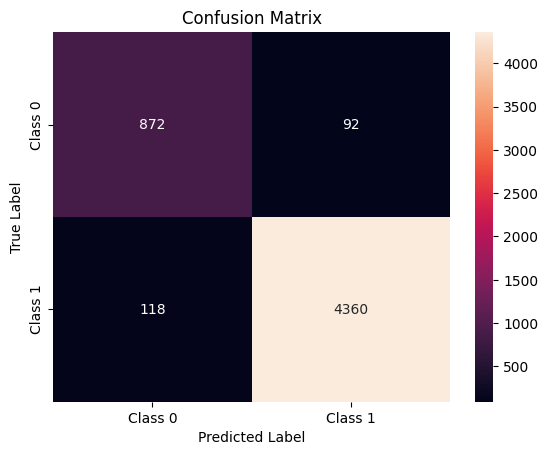

In [ ]:
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(true_labels, pred_labels)
sns.heatmap(conf, annot=True, fmt='g', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1']) 
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
history['test_loss'].append(test_loss)
history['test_acc'].append(test_acc)
history['test_f1'].append(test_f1)
history['test_report'].append(test_report)

final_history = dict(history)
final_history

{'train_loss': [0.35055168945060855,
  0.33023229403707327,
  0.34680260536978663,
  0.20139634291113345],
 'train_acc': [0.8711315739510157,
  0.8994446554015568,
  0.9458420353142206,
  0.9718530472754889],
 'train_f1': [0.7862775040120967,
  0.8208682160623745,
  0.8932451852704519,
  0.9431964982633756],
 'train_report': [{'0': {'precision': 0.530893883951908,
    'recall': 0.8433814980900183,
    'f1-score': 0.6516104196073399,
    'support': 6021},
   '1': {'precision': 0.9710478646648859,
    'recall': 0.8757579952928146,
    'f1-score': 0.9209445884168536,
    'support': 36115},
   'accuracy': 0.8711315739510157,
   'macro avg': {'precision': 0.7509708743083969,
    'recall': 0.8595697466914165,
    'f1-score': 0.7862775040120967,
    'support': 42136},
   'weighted avg': {'precision': 0.9081523093707707,
    'recall': 0.8711315739510157,
    'f1-score': 0.8824582339835404,
    'support': 42136}},
  {'0': {'precision': 0.6086744639376218,
    'recall': 0.8297624979239329,
    '

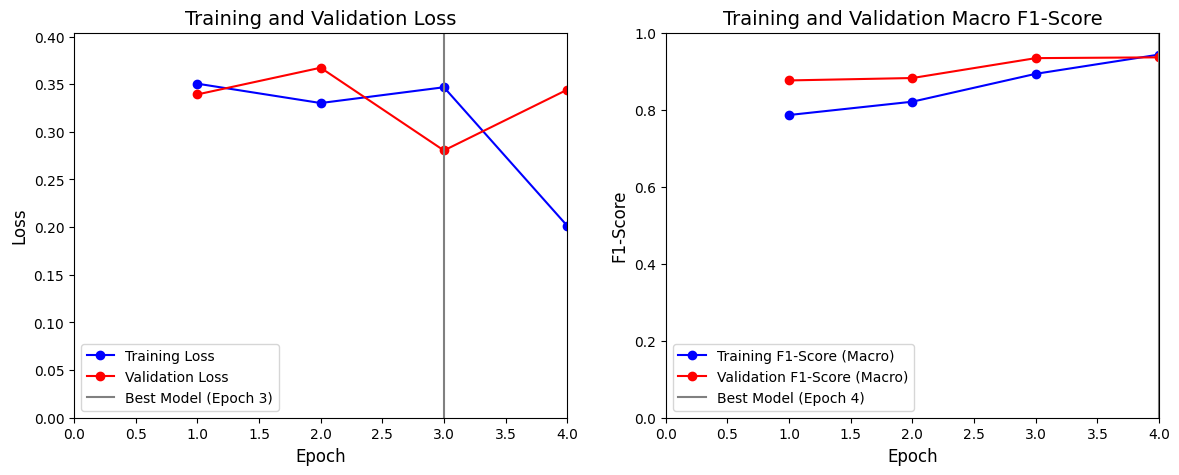

In [ ]:
epochs = range(1, len(history['train_loss']) + 1)
plt.figure(figsize=(14, 5))

# plot 1
plt.subplot(1, 2, 1) 
plt.plot(epochs, history['train_loss'], 'b-o', label='Training Loss')
plt.plot(epochs, history['val_loss'], 'r-o', label='Validation Loss')
best_epoch_loss = np.argmin(history['val_loss']) + 1
plt.axvline(x=best_epoch_loss, color='gray', linestyle='-', label=f'Best Model (Epoch {best_epoch_loss})')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0, max(max(history['train_loss']), max(history['val_loss'])) * 1.1) 
plt.xlim(0, len(epochs))

# plot 2: f1-score curve
plt.subplot(1, 2, 2) 
plt.plot(epochs, history['train_f1'], 'b-o', label='Training F1-Score (Macro)')
plt.plot(epochs, history['val_f1'], 'r-o', label='Validation F1-Score (Macro)')
best_epoch_f1 = np.argmax(history['val_f1']) + 1
plt.axvline(x=best_epoch_f1, color='gray', linestyle='-', label=f'Best Model (Epoch {best_epoch_f1})')
plt.title('Training and Validation Macro F1-Score')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.legend()
plt.ylim(0, 1)
plt.xlim(0, len(epochs))
plt.show()